In [1]:
import urllib.request
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# roundabout data has been extracted from openstreetmap with overpass API: https://overpass-turbo.eu/s/1nh3
gdf_swimmingpools = gpd.read_file('data/openstreetmap-martinique-swimming-pools.geojson')
gdf_swimmingpools['geometry'] = gdf_swimmingpools['geometry'].apply(lambda x: x.centroid)

In [3]:
COMMUNES_FILE = 'data/communes-martinique.geojson'

gdf_mq = gpd.read_file(COMMUNES_FILE)

In [4]:
# join -> swimming pool inside a city polygon
# left join is selected as I dont know how to deal with swimming pool that were not found inside any city 
# 8 such cases were founds, at least some seem legits => city shapes not very precise ...
gpd_joined = gpd.sjoin(gdf_mq, gdf_swimmingpools[['id', 'geometry']], how="inner", predicate='intersects').sort_values('code')

# count nb swimming pool per city
gdf_mq = gdf_mq.merge(gpd_joined[['code', 'id']].groupby(by=['code']).agg(nb_swimming_pools=('id', 'size')).reset_index(), on="code", how="left").fillna(0)

In [5]:
# insee data : https://www.insee.fr/fr/statistiques/6011060?sommaire=6011075
INSEE_URL_POP_LEGALE_MQ_2019 = 'https://www.insee.fr/fr/statistiques/fichier/6011060/dep972.xlsx'
INSEE_LOCAL_FILE_POP_LEGALE_MQ_2019 = 'output-tmp/insee-mq-pop-legale-2019.xlsx'

urllib.request.urlretrieve(INSEE_URL_POP_LEGALE_MQ_2019, INSEE_LOCAL_FILE_POP_LEGALE_MQ_2019)
df = pd.read_excel(INSEE_LOCAL_FILE_POP_LEGALE_MQ_2019, skiprows=7, sheet_name="Communes", engine="openpyxl")
df['code'] = df['Code département'].astype(str).str[:2] + df['Code commune'].astype('str')

gdf_mq = gdf_mq.merge(df[['code', 'Population municipale', 'Population comptée à part', 'Population totale']], on="code")
gdf_mq['swimming_pool_per_1000h'] = 1000 * gdf_mq['nb_swimming_pools'] / gdf_mq['Population municipale']

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


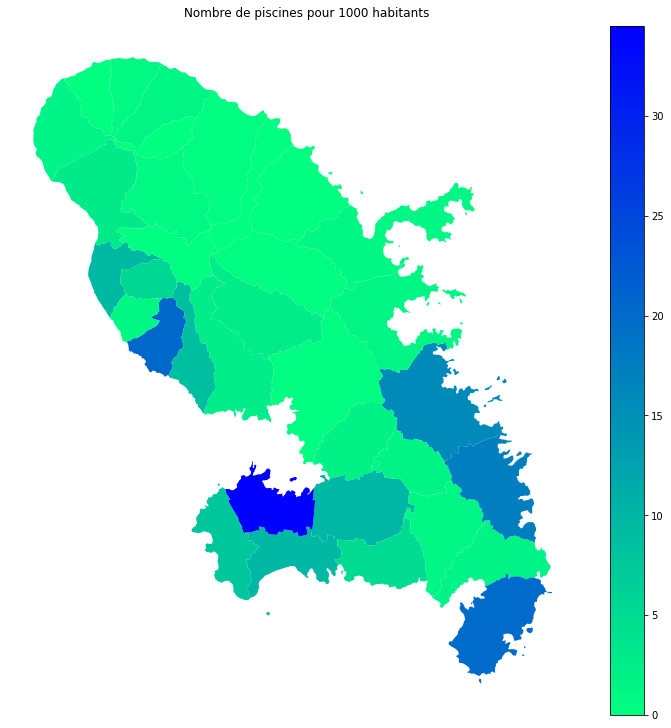

In [6]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))
fig.suptitle("Nombre de piscines pour 1000 habitants")
gdf_mq.plot(ax=ax, column='swimming_pool_per_1000h', legend=True, cmap='winter_r')
_ = ax.axis('off')

fig.savefig('output/2022-11-08.png', facecolor='white')